# **ASL Alphabet Classification** 
##5 Convolutional Layers + 2 Fully Connected Layers

##**Connect to Kaggle**

In [ ]:
 ! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

In [ ]:
 ! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

##**Import Dataset**

In [ ]:
! kaggle datasets download -d grassknoted/asl-alphabet
! unzip asl-alphabet.zip -d Train

Output streaming troncato alle ultime 5000 righe.
  inflating: Train/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: Train/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: Train/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: Train/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: Train/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: Train/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: Train/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: Train/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: Train/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: Train/asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: Train/asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: Train/asl_alphabet_train/as

In [ ]:
pip install split-folders tqdm

In [ ]:
import splitfolders
! mkdir Subsets
splitfolders.ratio("/content/Train/asl_alphabet_train/asl_alphabet_train", output="/content/Subsets", seed=1337, ratio=(0.26, 0.74), group_prefix=None)

Copying files: 87000 files [00:17, 4919.47 files/s]


In [ ]:
! mkdir asl-alphabet
splitfolders.ratio("/content/Subsets/train", output="/content/asl-alphabet", seed=1337, ratio=(.76, .13, .11), group_prefix=None)

Copying files: 22620 files [00:04, 5110.85 files/s]


In [ ]:
%rm -rf /content/Train 
%rm -rf /content/Subsets
%rm -rf /content/asl-alphabet.zip

In [ ]:
import os
dest_dir = "/content/asl-alphabet"
os.listdir(dest_dir)

['train', 'val', 'test']

In [ ]:
def dt_info(path, types):
    cls_name=[]
    f_p_cl=[]
    totalClasses=0
    totalFiles=0
    for base, cls, files in os.walk(path):
        for Classes in cls:
            totalClasses += 1
            cls_name.append(Classes)
        for Files in files:
            totalFiles += 1
        f_p_cl.append(len(files))
    print(types, 'set description')
    print('Total Number of classes',totalClasses)
    print('Total Number of files',totalFiles)
    files_per_classes = dict(zip(cls_name, f_p_cl[1:]))
    return files_per_classes

In [ ]:
dt_info('/content/asl-alphabet/train', types='train')

train set description
Total Number of classes 29
Total Number of files 17168


{'A': 592,
 'B': 592,
 'C': 592,
 'D': 592,
 'E': 592,
 'F': 592,
 'G': 592,
 'H': 592,
 'I': 592,
 'J': 592,
 'K': 592,
 'L': 592,
 'M': 592,
 'N': 592,
 'O': 592,
 'P': 592,
 'Q': 592,
 'R': 592,
 'S': 592,
 'T': 592,
 'U': 592,
 'V': 592,
 'W': 592,
 'X': 592,
 'Y': 592,
 'Z': 592,
 'del': 592,
 'nothing': 592,
 'space': 592}

In [ ]:
dt_info('/content/asl-alphabet/val', types='val')

val set description
Total Number of classes 29
Total Number of files 2929


{'A': 101,
 'B': 101,
 'C': 101,
 'D': 101,
 'E': 101,
 'F': 101,
 'G': 101,
 'H': 101,
 'I': 101,
 'J': 101,
 'K': 101,
 'L': 101,
 'M': 101,
 'N': 101,
 'O': 101,
 'P': 101,
 'Q': 101,
 'R': 101,
 'S': 101,
 'T': 101,
 'U': 101,
 'V': 101,
 'W': 101,
 'X': 101,
 'Y': 101,
 'Z': 101,
 'del': 101,
 'nothing': 101,
 'space': 101}

In [ ]:
dt_info('/content/asl-alphabet/test', types='test')

test set description
Total Number of classes 29
Total Number of files 2523


{'A': 87,
 'B': 87,
 'C': 87,
 'D': 87,
 'E': 87,
 'F': 87,
 'G': 87,
 'H': 87,
 'I': 87,
 'J': 87,
 'K': 87,
 'L': 87,
 'M': 87,
 'N': 87,
 'O': 87,
 'P': 87,
 'Q': 87,
 'R': 87,
 'S': 87,
 'T': 87,
 'U': 87,
 'V': 87,
 'W': 87,
 'X': 87,
 'Y': 87,
 'Z': 87,
 'del': 87,
 'nothing': 87,
 'space': 87}

##**Custom dataset**

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader
from pathlib import Path 
from PIL import Image
from matplotlib import pyplot as plt

In [ ]:
class MyDataset(Dataset):
  def __init__(self, dset_dir, train=True, val= False, transforms=T.Compose([])): 
    if train: 
      split="train" 
    elif val: 
      split="val" 
    else: 
      split="test" 
    self.dset_dir = Path(dset_dir)/split 
   

    self.transforms = transforms

    self.files = []

    folders = sorted(os.listdir(self.dset_dir)) 
    for folder in folders: 
    
    
      class_idx = folders.index(folder)

      folder_dir = self.dset_dir/folder

      files = os.listdir(folder_dir) 

      self.files += [{"file": folder_dir/x, "class": class_idx} for x in files] 
     

  def __len__(self):
    return len(self.files) 

  def __getitem__(self, i):
    item = self.files[i] 
    file = item['file']
   
    class_idx = torch.tensor(item['class']) 

    img = Image.open(file).convert("RGB") 
    img = self.transforms(img) 
    return img, class_idx 

In [ ]:
transforms = T.Compose([
        T.Resize((200, 200)), 
        T.ToTensor(), 
        T.Normalize(0.5, 0.5) 
    ]) 

In [ ]:
train_dset = MyDataset(dest_dir, train=True, val=False, transforms=transforms)
val_dset = MyDataset(dest_dir, train=False, val=True, transforms=transforms)
test_dset = MyDataset(dest_dir, train=False, val=False, transforms=transforms)

In [ ]:
data, label = train_dset[0] 
print(data.shape)

torch.Size([3, 200, 200])


In [ ]:
train_loader = DataLoader(train_dset, batch_size=64, shuffle=True, drop_last=True, num_workers=2)
val_loader = DataLoader(val_dset, batch_size=64, shuffle=False, drop_last=False, num_workers=2)
test_loader = DataLoader(test_dset, batch_size=64, shuffle=False, drop_last=False, num_workers=2)

In [ ]:
inputs, labels = next(iter(train_loader))
print(inputs.shape) 
print(labels.shape)

torch.Size([64, 3, 200, 200])
torch.Size([64])


##**Classification**

In [ ]:
class SimpleCNN(nn.Module):
  #Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 3
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 4
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 5
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x)  
    return x

In [ ]:
# Create the model
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)


In [ ]:
test_x, _ = train_dset[0]
test_x.size() #size of a sample

torch.Size([3, 200, 200])

In [ ]:
test_x = test_x.unsqueeze(dim=0) #DIMENSION 0
test_x.size()

torch.Size([1, 3, 200, 200])

In [ ]:
output = model(test_x) 
output.shape

torch.Size([1, 128, 12, 12])

In [ ]:
out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

18432


In [ ]:
class MyCNN(nn.Module):
  #Constructor
  def __init__(self, in_size=3, out_size=29, use_norm=False):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
         # Layer 1
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 3
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 4
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 5
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # Create fully-connected layers
    self.fc_layers = nn.Sequential(
        # a first FC layer
        nn.Linear(18432, 4096), #The fully connected -> input, output
        nn.ReLU(),
        # second FC layer
        nn.Linear(4096, 1024),
        nn.ReLU(),
        # the final Classification Layer
        nn.Linear(1024, 29) #number of classes
    )

  # Forward
  def forward(self, x):
    
    x = self.conv_layer(x) 
    x = x.view(x.size(0), -1) 
    output = self.fc_layers(x) 
    return output

In [ ]:
net = MyCNN()
output = net(test_x)
output.shape

torch.Size([1, 29])

In [ ]:
import torch
def train(net, loaders, optimizer, criterion, epochs=100, dev=torch.device('cpu')):
    try:
        net = net.to(dev) 
        print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []} 
        history_accuracy = {"train": [], "val": [], "test": []}
        # Process each epoch
        for epoch in range(epochs): 
            print(f"Running epoch: {epoch}")
            sum_loss = {"train": 0, "val": 0, "test": 0} 
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]: 
                 if split == "train":
                    net.train()
                 else:
                    net.eval() 
                
                 for (input, labels) in loaders[split]: 
                    
                    input = input.to(dev)
                    labels = labels.to(dev)
                    
                    optimizer.zero_grad() 
                    
                    pred = net(input)
                    loss = criterion(pred, labels) 
                    
                    sum_loss[split] += loss.item()
                    
                    if split == "train": 
                        
                        loss.backward()
                       
                        optimizer.step()
                   
                    _,pred_labels = pred.max(1) 
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0) 

                    
                    sum_accuracy[split] += batch_accuracy
            
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}

            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split) 
        plt.legend()
        plt.show()

MyCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=18432, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=1024, bias=Tr

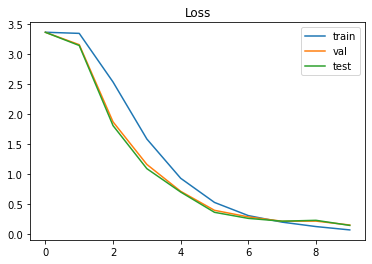

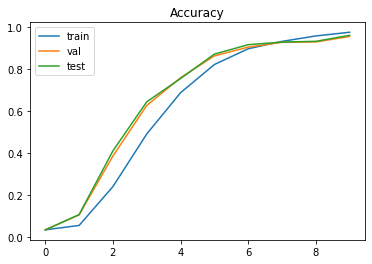

In [ ]:
import torch.optim as optim

dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

net = MyCNN()
optimizer = optim.SGD(net.parameters(), lr = 0.05) #optimizer 
criterion = nn.CrossEntropyLoss() #define criterion 


loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

train(net, loaders, optimizer, criterion, epochs=10, dev=dev)